Author: Brian Erichsen Fagundes

Data Manipulation and NN architecture

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

#data = pd.read_csv('stock_data.csv')
# fetches data from excel file
excel_data = pd.read_excel('historical_prices.xlsx', sheet_name=None)
combined_data = pd.DataFrame() # initiate empty data that will be combined

# per each sheet in excell file set stock to specific stock and concatenate data
for sheet_name, df in excel_data.items():
    df['Stock'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

#print(combined_data.info())
#print(combined_data.columns)
#print(combined_data.head())
#print(combined_data.tail())

# this step is crucial for NN LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))

# 2D numpy array from scaling columns
scaled_data = scaler.fit_transform(combined_data[['Close', 'Volume']])
#scaled_data[:,0] - all rows from 1st column - Close
#scaled_data[:, 1] - Volume

sequence_length = 60
x_train, y_train = [],[]
# splits x_t and y_t
# Len of data number of training examples, sequence len is number of steps, 1 feature
# For y_train - 1D array; since we keeping only stock prices (1 feature)
for i in range(sequence_length, len(scaled_data)):
    #only keeping close price for now
    # for using volume as well --
    # x_train.append(scaled_data[i-sequence_length:i, :])
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])# close for the target

# transforms data into numpy array for model
x_train, y_train = np.array(x_train), np.array(y_train)
# reshapes it to 3D (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# model.compile - learn process before training the model
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)
model.fit(x_train, y_train, batch_size=1, epochs=1)

model.save('stock_prediction_model.h5')




/var/folders/vz/hr6jrn1n0ggf1mxbfs500y4m0000gn/T/ipykernel_25477/3964615603.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat([combined_data, df], ignore_index=True)
/Users/brianerichsenfagundes/Desktop/6017/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2576/2576 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0056


In [12]:
from sklearn.model_selection import train_test_split

#splitting the data into train and test sets
sequence_length = 60
x_data, y_data = [], []

for i in range(sequence_length, len(scaled_data)):
    x_data.append(scaled_data[i-sequence_length:i, 0])
    y_data.append(scaled_data[i, 0])

x_data, y_data = np.array(x_data), np.array(y_data)
train_size = int(len(x_data) * 0.8)
#[x:y] -- from 0 to train size and from train size to the end
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

#reshape data for LSTM model which expects a 3D
# input - samples, time steps and number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
model.fit(x_train, y_train, batch_size=1, epochs=1)

2060/2060 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0030


In [14]:
from sklearn.metrics import mean_squared_error
# Model Evaluation
predicted_stock_price = model.predict(x_test)
# Mean squared error calculation
mse = mean_squared_error(y_test, predicted_stock_price)
sqmse = np.sqrt(mse)
print(f'Test MSE: {mse:.4f}')
print(f'Test SQMSE: {sqmse:.4f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE: 0.0001
Test SQMSE: 0.0114


So far it seems that model can predictict well the prices of stocks.


Using only Close price -- MSE: 0.0017 and SQMSE: 0.0414

In [15]:
# Adding Cross Validation for further testing accuracy
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(x_data):
    x_train_cv, x_test_cv = x_data[train_index], x_data[test_index]
    y_train_cv, y_test_cv = y_data[train_index], y_data[test_index]
    
    x_train_cv = np.reshape(x_train_cv, (x_train_cv.shape[0], x_train_cv.shape[1], 1))
    x_test_cv = np.reshape(x_test_cv, (x_test_cv.shape[0], x_test_cv.shape[1], 1))

    model.fit(x_train_cv, y_train_cv, batch_size=1, epochs=1)
    
    predictions = model.predict(x_test_cv)
    mse_cv = mean_squared_error(y_test_cv, predictions)
    print(f'MSE for fold: {mse_cv:.4f}')


431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0014
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0008
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0014
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0020
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0022
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0015
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0028
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0008
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0016
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for fold: 0.0007


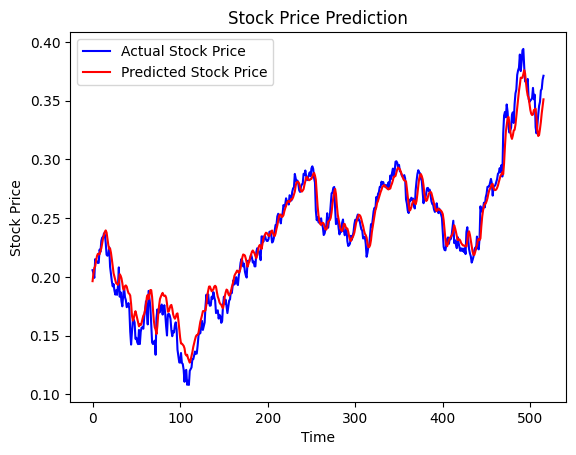

In [16]:
import matplotlib.pyplot as plt

plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Notes: Test it with Close and Volume feature and compare accuracy of both & adding the S&P 500 data as well and test its accuracy and how well it impacts overall predictions. Currently the prediction is the next day -- we could also dynamically do a x variable number of days ahead to test its prediction.

In [17]:
from tensorflow.keras.models import load_model
# this is just an initial script test to display specific next day closing price of specific stock

ticker = 'TSLA'

new_data = scaler.fit_transform(combined_data[['Close']])
x_input = np.array([scaled_data[:, 0]])
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

model = load_model('stock_prediction_model.h5')
predicted_stock_price = model.predict(x_input)

predicted_price = scaler.inverse_transform(
    np.array([predicted_stock_price[0], [0]])
)[0][0]

print(f'Predicted Closing Price for {ticker} for 08-19-2024: {predicted_price:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted Closing Price for TSLA for 08-19-2024: 230.44


So far NN predictis one day ahead closing price of a given stock. Let's change the model so that the output is 2D instead 1D so we can predicti n days in the future from today.

In [18]:
# this new model will have 2 Y output so that we can predict n days in the future the close
# price of a given stock

sequence_length = 60
n_future = 5 #number of days ahead we want to predict
x_train, y_train = [],[]
# splits x_t and y_t
# Len of data number of training examples, sequence len is number of steps, 1 feature
# For y_train - 1D array; since we keeping only stock prices (1 feature)
for i in range(sequence_length, len(scaled_data) - n_future + 1):
    #only keeping close price for now
    # for using volume as well --
    # x_train.append(scaled_data[i-sequence_length:i, :])
    x_train.append(scaled_data[i-sequence_length:i])
    y_train.append(scaled_data[i:i+n_future, 0])# close for the target

# transforms data into numpy array for model
x_train, y_train = np.array(x_train), np.array(y_train)
# reshapes it to 3D (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(n_future)
])

# model.compile - learn process before training the model
# adam - adaptive learning - and MSE for regression
model.compile(optimizer='adam', loss='mean_squared_error')
# trains the model in provided data -- x input; y target (labels)
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)
model.fit(x_train, y_train, batch_size=1, epochs=1)

model.save('stock_prediction_model2.h5')

/Users/brianerichsenfagundes/Desktop/6017/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2572/2572 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0104
